#BA476 Machine Learning Practical Assignment - Exploring the Bias-Variance Tradeoff with Lasso


The purpose of this assignment is to explore the bias-variance trade-off while practicing your Pandas,
Scikit-learn, Matplotlib, and IPython Notebook skills. 



To complete this assignment, you will need to  use Scikit-learn's `Lasso()` model to fit a number of Lasso regressions to a CA housing dataset. Each Lasso will be fit using a different value of $\lambda$, and you will summarise your results by producing two figures. 

Figure 1 should contain the following elements:
1. The x-axis should represent $\lambda$.
2. The y-axis should be MSE.
3. The plot should contain two lines with different colors: one for the MSE of your train data, and one for your test MSE.
4. Finally, the plot should be annotated with two points (the cross in the example figure below) to show the minimum point on the test MSE curve.




The second figure will show how the model coefficients are forced to zero as $\lambda$ increases. Follow these guidelines: 
1. The x-axis should represent $\lambda$.
2. The y-axis should be show coefficient magnitude.
3. The plot should contain a line for the coefficient of each predictor. 
4. Include a vertical line to indicate the $\lambda$ where the minimum test MSE occured.

An example is included below. Remember to label your axis, include legends,  etc. 

![](https://docs.google.com/uc?export=download&id=11Jkr1789kE-IFRMWgrp5Sf3tO3mUnB1z) 


The maximum points achievable is 60. 


## 1. Setup and preprocessing [3]
### 1.1. Import the libraries

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#this will mute errors that made your final pdf less legible
import warnings
warnings.filterwarnings('ignore')

### 1.2. Load the CA housing dataset and pre-process our data

The CA housing dataset is available on the course page. Download it, store it on your Google Drive and read it into Colab.

 Now we can read the data and create a dataframe. You will have to
edit the path below to the file’s location on your Google Drive.

In [190]:
# load the data
df = pd.read_csv('housing2019.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The total_bedrooms column has missing data that we will impute using the median.

In [191]:
total_bedrooms_median = df["total_bedrooms"].median()
df["total_bedrooms"].fillna(value=total_bedrooms_median, inplace=True)

We will also remove the latitude and longitude columns from the data and use one-hot encoding on the ocean_proximity column

In [192]:
df.drop(labels=["longitude", "latitude"], axis=1, inplace=True)

We saw an example of how to do one-hot encoding using an sklearn transformer in class. For the sake of variety we'll use pandas here. 

In [193]:
ocean_dummies = pd.get_dummies(df.ocean_proximity, )
df.drop(labels="ocean_proximity", axis=1, inplace=True)
df = df.join(ocean_dummies)
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


### 1.3. Visualize our Data and Try to Find Outliers (3 Points)
Now that we have imputed null values, created our dummies, and added a helpful new predictor, we should check to make sure we do not have any outliers in our numerical columns. Particularly, let's see if there are any outliers in the population or total_rooms column. 

For this plot, use population as x and total_rooms as y to create a scatter plot.

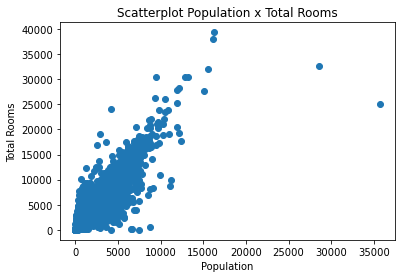

In [194]:
#Create a scatter plot with x as population and y as total rooms
x = df['population']

y = df['total_rooms']

plt.scatter(x, y)
plt.title('Scatterplot Population x Total Rooms')
plt.xlabel('Population')
plt.ylabel('Total Rooms')
plt.show()

Based on this process, it looks like we have two instances with abnormally large populations and two instances with abnormally large total_rooms. Use filtering on your dataframe to remove these four outliers (you can do this one by one)

In [195]:
#Filter out the 2 large instances on the population axis

#q = df['population'].nlargest(2)
#q2 = df['total_rooms'].nlargest(2)

df = df.loc[df['population'] <= 25000]
df = df.loc[df['total_rooms'] <= 35000]

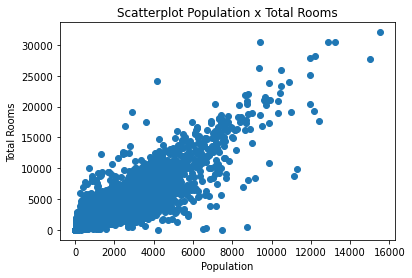

In [196]:
#Create a scatter plot with x as population and y as total rooms

x = df['population']
y = df['total_rooms']

plt.scatter(x, y)
plt.title('Scatterplot Population x Total Rooms')
plt.xlabel('Population')
plt.ylabel('Total Rooms')
plt.show()

There are still some instances larger than others, but our scatter plot has less obvious outliers than before, so we can move into splitting the data.

### 1.4. Create our training and testing sets

Next, we will split our dataset in train and test.
For simplicity and consistency, we will use rows 0 to 5,000 as training data, and rows 15,001 to 18,000 as test
data. (In practice, you would split your data in train and test randomly.)

In [197]:
#Split into train and test
X_train = df.loc[:5000, df.columns != "median_house_value"]
y_train = df.loc[:5000, "median_house_value"][:, np.newaxis]

X_test = df.loc[15000:18000, df.columns != "median_house_value"]
y_test = df.loc[15000:18000, "median_house_value"][:, np.newaxis]

#Select the numerical (non-categorical) predictor columns
numerical = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
             'households', 'median_income']

##2. Train exploratory models and do feature engineering [10]
###2.1. Create a baseline model (2 points)
Below, fit and evaluate a Lasso model using the default choice of $\lambda$ (alpha), This will give us a baseline to see whether or not our model is improving.

In [198]:
# For each step (instantiate, fit, predict, assess)
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso

#instantiate
lasso = Lasso()

#fit
lasso.fit(X_train, y_train)

#predict
y_test_predict = lasso.predict(X_test)  

#assess
baseline_mse = mean_squared_error(y_test, y_test_predict)
print(np.sqrt(baseline_mse), baseline_mse)

115069.0042111281 13240875730.14062


### 2.2. Apply Log Transforms to Variables to Increase Predictive Power (5 points)
In this section, we will investigate the distributions of some of our variables and see if a log transform is needed. Recall that a log transform may be useful when predictor values follow  a log-normal distribution, span several orders of magnitudes or are very skewed. 

First, let's   look at some of our predictors and see if any of them follow a distribution other than the normal distribution. 

Text(0.5, 1.0, 'households histogram')

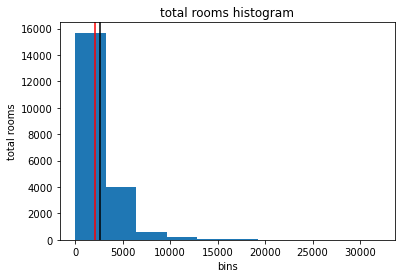

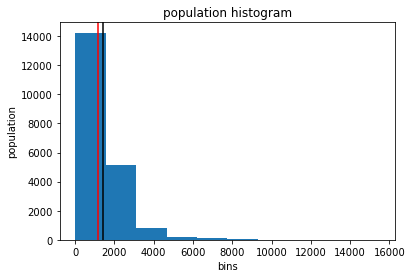

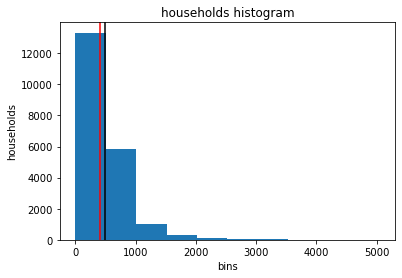

In [199]:
hist_columns = [ "total_rooms","population", "households"]

# For each column in hist_columns draw a histogram and vertical lines for the mean and median 
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(df["total_rooms"])

plt.axvline(x=df["total_rooms"].mean(),
            color='black')
plt.axvline(x=df["total_rooms"].median(),
            color='red')
plt.xlabel("bins")
plt.ylabel("total rooms")
plt.title("total rooms histogram")


fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(df["population"])

plt.axvline(x=df["population"].mean(),
            color='black')
plt.axvline(x=df["population"].median(),
            color='red')
plt.xlabel("bins")
plt.ylabel("population")
plt.title("population histogram")


fig3 = plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)
n, bins, patches = ax3.hist(df["households"])

plt.axvline(x=df["households"].mean(),
            color='black')
plt.axvline(x=df["households"].median(),
            color='red')
plt.xlabel("bins")
plt.ylabel("households")
plt.title("households histogram")

These variables do ll appear to be fairly skewed, let's see if a log-transform is useful here.  Below, you have a list of columns to apply a log transform to. 
For each of those columns $X_i$, replace their values with $\log(X_i)$ by using np.log (or something similar) in both  X_test and X_train. We will use the transformed columns for the rest of the assignment. You may use any method you want, for example an sklearn function-transformer or a simple loop. 

In [200]:
transform_cols = ["total_rooms","population","households"]

# for each of the above columns, apply the required transformation in both X_test and X_train

for x in range(len(transform_cols)):
    
    current = transform_cols[x]
    df[current] = np.log(df[current])

df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,41.0,6.779922,129.0,5.774552,4.836282,8.3252,452600.0,0,0,0,1,0
1,21.0,8.867709,1106.0,7.783641,7.037028,8.3014,358500.0,0,0,0,1,0
2,52.0,7.290975,190.0,6.206576,5.176150,7.2574,352100.0,0,0,0,1,0
3,52.0,7.149917,235.0,6.324359,5.389072,5.6431,341300.0,0,0,0,1,0
4,52.0,7.394493,280.0,6.336826,5.556828,3.8462,342200.0,0,0,0,1,0


Plot the transformed variables, and indicate the location of the mean and median as before. You will notice that the skew has been reduced.


Text(0.5, 1.0, 'households histogram')

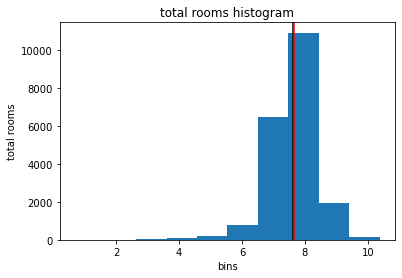

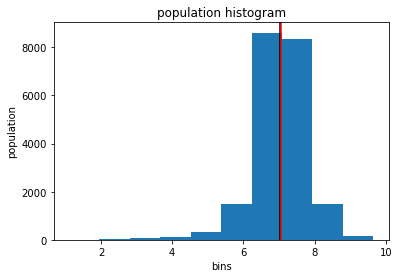

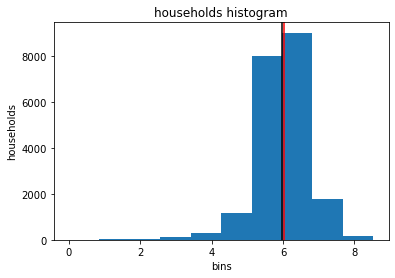

In [201]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(df["total_rooms"])
plt.xlabel("bins")
plt.ylabel("total rooms")
plt.title("total rooms histogram")

plt.axvline(x=df["total_rooms"].mean(),
            color='black')
plt.axvline(x=df["total_rooms"].median(),
            color='red')

fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(df["population"])

plt.axvline(x=df["population"].mean(),
            color='black')
plt.axvline(x=df["population"].median(),
            color='red')
plt.xlabel("bins")
plt.ylabel("population")
plt.title("population histogram")

fig3 = plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)
n, bins, patches = ax3.hist(df["households"])

plt.axvline(x=df["households"].mean(),
            color='black')
plt.axvline(x=df["households"].median(),
            color='red')
plt.xlabel("bins")
plt.ylabel("households")
plt.title("households histogram")

Now that the training and testing sets have been transformed, build another model to see if this affected the accuracy of the model. 

In [202]:
transformed_mse = -1

# build a new baseline model

#instantiate
lasso = Lasso(normalize = True)

#fit
lasso.fit(X_train, y_train)

#predict
y_test_predict = lasso.predict(X_test)  

#assess
trans_mse = mean_squared_error(y_test, y_test_predict)
print(trans_mse)

13250434258.554272


it's not a big change, but you'll notice that our accuracy has improved just from finding a different representation for some of our predictors. Now it's time to tune $\lambda$.

## 3. Tune $\lambda$  [33]
### 3.1. For each value of $\lambda$, fit and evaluate a mode (10 points)

Next, we will use the `Lasso()` class from Scikit-learn to fit a set of Lasso regressions for 100 different $\lambda$ values. We generate
 (logarithmically) evenly spaced $\lambda$'s between $10^{-3}$ and $10^3$ with Numpy. 

In [203]:
num_lambdas = 30
lambdas = np.logspace(2, 5, num_lambdas)

The following data structures should capture each model's predictions and coefficients. Note that `y_train_hat` has a number of rows equal to the number of training instances we have and  100 columns, one for each of the models we will train.  

In [204]:
y_train_hat = np.zeros((y_train.shape[0], num_lambdas))
y_test_hat = np.zeros((y_test.shape[0], num_lambdas))
coefficients = np.zeros((X_train.shape[1], num_lambdas))


Now we are ready to fit our models by looping through the vector of regularization parameters. 

In [205]:
# Iterate over lambdas, train a model, make predictions, store coeff.

for i, current_lambda in enumerate(lambdas):

     # instantiate and fit model 
        lasso = make_pipeline(StandardScaler(), Lasso(alpha = current_lambda))
        #lasso = Lasso(alpha = current_lambda)
        
        lasso.fit(X_train, y_train)

     # make predictions on the training and testing sets 
        
        pred_ytrain = lasso.predict(X_train)
        pred_ytest = lasso.predict(X_test)
        
        y_train_hat[:, i] = pred_ytrain
        y_test_hat[:, i] = pred_ytest
        coefficients[:, i] = lasso[-1].coef_ 
        
print(coefficients)
#print(y_test_hat)
#print(y_train_hat)

[[ 6.48293557e+03  6.45875942e+03  6.42671604e+03  6.37714813e+03
   6.31413029e+03  6.23531319e+03  6.13589242e+03  6.00970472e+03
   5.84982084e+03  5.64707075e+03  5.38990131e+03  5.06382199e+03
   4.64974029e+03  4.12440237e+03  3.41866402e+03  2.45250270e+03
   1.12235072e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.09989650e+02 -4.99647139e+02 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.7

### 3.2. Compute MSEs (5 points)
Using these predictions, we are now ready to compute MSEs. Specifically, we want to create two MSE vectors called `mse_train` and `mse_test`, respectively, each containing 100 different values (one for each model we trained). 

In [206]:
# mse_train, mse_test = None, None
# # your code here

mse_train = []
mse_test = []


for c in range(len(y_train_hat[0])): #100
    dif = 0
    num_c = c
    for r in range(len(y_train_hat)): #5001
        dif += (y_train[r] - y_train_hat[r][num_c])**2
    
    dif = np.mean(dif)
    mse_train.append(dif)
    

for c in range(len(y_test_hat[0])):
    dif = 0
    num_c = c
    for r in range(len(y_test_hat)):
        dif += (y_test[r] - y_test_hat[r][num_c])**2
    
    dif = np.mean(dif)
    mse_test.append(dif)


print(mse_train)
print(mse_test)

[17798528754232.035, 17800138779676.156, 17802684955651.574, 17804799382565.527, 17808236616587.96, 17813827198865.613, 17822808985310.93, 17837259335775.098, 17860566229464.348, 17898140694204.75, 17958703035035.75, 18056333131266.777, 18213548194683.098, 18466830138833.137, 18838189942265.902, 19380588738347.414, 19849101051980.906, 20126484346632.15, 20484827514056.746, 21061849636068.938, 21812812412048.1, 22646991795393.715, 23989780444237.47, 26152035819111.656, 29633854942089.277, 34526984198527.24, 42205334240650.695, 50854951608560.82, 57958864349459.16, 57958864349459.16]
[39758783763415.56, 39766150894398.734, 39773965876132.375, 39728595847519.81, 39671747680920.58, 39600654420461.98, 39512007772200.63, 39402433906207.27, 39268003391183.7, 39104962668545.97, 38910273183930.21, 38682865727489.47, 38426143394947.75, 38151485434951.29, 37876313843148.55, 37632313479001.68, 37208221715906.4, 36326402965501.82, 34935819014872.117, 33406040023998.66, 33174930927568.223, 333400747

'l### 3.3. Plot the model accuracy as $\lambda$ changes (9 points)

First, it will be helpful to determine which choice of $\lambda$ lead to the smallest test MSE.  We will store the index of this $\lambda$ value in a variable called `minidx`. Also create a variable for the lowest value in mse_test called `tuned_mse`.

In [207]:
# minidx = 

# tuned_mse = # your code here
tuned_mse = min(mse_test)
print(tuned_mse)

minidx = mse_test.index(min(mse_test))
print(minidx)

33174930927568.223
20


Now we have everything we need to create the first figure. You may have to brush up on your matplotlib skills, and remember to include a legend and label your axes. 

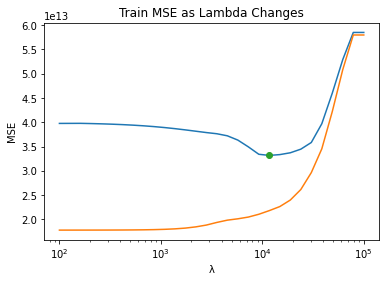

In [208]:
# plt.plot(lambdas, ..., label= ...)

fig,ax=plt.subplots()

ax.plot(lambdas, mse_test, label = "MSE Test")
ax.plot(lambdas, mse_train, label = "MSE Train")
ax.plot(lambdas[minidx], mse_test[minidx], marker = 'o')

ax.set_xscale('log')

ax.set_xlabel("λ")
ax.set_ylabel("MSE")
ax.set_title("Train MSE as Lambda Changes")


plt.show()

Now that we have tuned our model, let's take a quick look at how much our model has improved. Print baseline_mse, transformed_mse, and tuned_mse. Below you can see how MSE test has improved as we've applied different steps. We can also see that with a few lines of code and extra steps, we can radically increase model accuracy without adding new features. 

In [209]:
print('Baseline MSE:', baseline_mse)
print('Transformed MSE:', transformed_mse)
print('Tuned MSE:', tuned_mse)

print('Total % Change in MSE:', (baseline_mse-(tuned_mse))/baseline_mse)

Baseline MSE: 13240875730.14062
Transformed MSE: -1
Tuned MSE: 33174930927568.223
Total % Change in MSE: -2504.4937153477763


### 3.4. Reflecting on Bias-Variance Tradeoff in Regard to Model Performance (5 points)

In 3-4 sentences discuss how the bias-variance tradeoff explains what we see in the chart depicting test and train MSE over our lambdas. For example, talk about how bias and variance are related to lambda and what an increased lambda does here. Feel free to talk about over and underfitting (4 points). 

The whole point of regularized regression, using Lasso and Ridge, is to add a little bit of bias into the model so that you can reduce variance (MSE). With Lasso and Ridge, the lambda penalty is essentially how far off you are going to push it from the testing set. Therefore, when you increase lambda, bias and variance will move inversely; with bias increasing and variance decreasing. Within the graph, you can see that as lambda increases the testing MSE decreases and the training MSE increases.

### 3.5. Feature engineering (4 points)
As we see above, tuning and transforming increased model performance by reducing MSE. Another way to do this, however, is feature engineering.

Remember that when doing feature engineering the idea is to find a higher-dimensional representation of the data that enables your estimator to learn additional structure. We can do this either by taking combinations of existing predictors, or by finding entirely new data and appending it to our dataset. One step we did not apply to this assignment was to create new features, though it could have helped our MSE improve even more. 

Suggest at least 1 new predictor that is derived from the current dataset, and at least one new predictor for which you will have to find external data sources. For the predictor using external data, where will you find it and what processing do you expect to have to do?

1 new predictor derived from current dataset: using longitude and lattitude variables to create a set of neighborhoods. I think this could be helpful since neighborhood and location often can determine median home prices. Or something in general with longitude and latitude I feel like could potentially enable a better fit.

1 new predictor from external source: mean sqrt feet per home. I think this would be very useful. Square feet largely affects property value, so a higher median square feet per home would be a great predictor to add. In ordr to find this, you would need to find a dataset that had the same longitudes and lattitudes and median square feet or total which could be divided by population. 

## 4. Investigate model coefficients [11]
###4.1.  Plot coefficient sizes as $\lambda$ changes (8 points)



We are ready to create the second figure and see how the regularization  affected the   coefficients of our model.  Since we want a line for the coefficient of every predictor, it may be useful to loop over the predictors: 

11


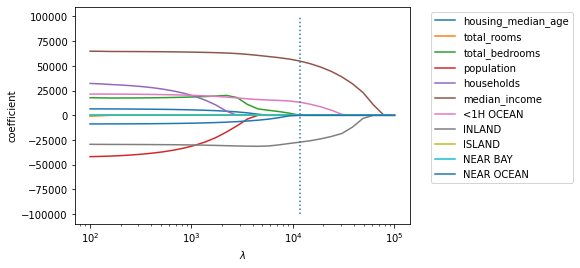

In [210]:
num_predictors = X_train.shape[1]

print(num_predictors)


for i in range(num_predictors):
    current = i
    plt.plot(lambdas, coefficients[i, :], label=X_test.columns[i])
    
plt.vlines(lambdas[minidx], -100000, 100000, linestyles = 'dotted')
plt.legend(bbox_to_anchor=(1.05, 1), loc = 'upper left')

plt.xticks(lambdas)
plt.xscale('log')

plt.xlabel("$\lambda$")
plt.ylabel("coefficient")

plt.show()

### 4.1. Discuss the coefficients of our best fitting model (3 points)

We already extracted the index of the model that performed best on the test set, so let's take a look at the coefficients of our best model to learn more. 

Suppose  you are considering investing in CA real estate: What are the main drivers of price in this market? Discuss brieﬂy in 1-2 sentences.


The coefficients that were the strongest on our best fitting model were: median income, inland, and less than 1 hour from the ocean. Out of these three, median income was especially strong. We can tell these are important predictors for the market since as lambda increased their values were still not at 0.

*Answer*

## Preparing for submission

To convert your notebook to html, change the string below to reflect the location of the notebook in your Google Drive. 

In [211]:
path_to_file = '/content/drive/My Drive/ba476-test/2021Fall/updates/PA1-regularised-regression.ipynb'

Now execute the code cell below. It will take a minute or two to run. After execution there should be an html file in the same Google Drive folder  where this notebook is located. Download the html file, open with your browser and print to pdf, then submit the pdf on the course page along with your notebook.

Note: this block of code occasionally gives trouble if your path contains spaces. If this happens please change your path/the location of the file and try again. 

In [212]:
!apt update
!apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

import re, pathlib, shutil
nbpath = pathlib.PosixPath(path_to_file)
!jupyter nbconvert "{nbpath.as_posix()}" --to html --output "{nbpath.stem.replace(" ", "_")}"

'apt' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


NotImplementedError: cannot instantiate 'PosixPath' on your system